In [3]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_40m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]
# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    en va plot un learning curve grace au code de ce lien http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("exemples de test")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="score du cross validation")
    plt.legend(loc="best")
    return plt

def plotLotsOfLearningCurves(a,b):
    """ en va plot bcp de learning curve http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
#plotLotsOfLearningCurves(X_trainFlat, Y_train)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='matrice d econfusion',
                          cmap=plt.cm.Blues):
    """
    en affiche la matrice de confusion
    en peut normalizer les donnees en metant normalize a true
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """methodes qui affiches les matrices de confusiondu model svc (comme exmeple) en normalizer et non normalizer"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["diagnostic" "IDC(-)", "diagnostic" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, sans la normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=' confusion matrix avec normalization')
    plt.show()
#runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [ ]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((1,1))(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((2,2))(input_img)
    tower_6 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
    tower_7 = Conv2D(86, (1,1), padding='same', activation='relu')(input_img)
    tower_7 = Conv2D(86, (3,3), padding='same', activation='relu')(tower_1)

    tower_8 = Conv2D(86, (1,1), padding='same', activation='relu')(input_img)
    tower_8 = Conv2D(86, (5,5), padding='same', activation='relu')(tower_2)

    tower_9 = MaxPooling2D((2,2))(input_img)
    tower_9 = Conv2D(86, (1,1), padding='same', activation='relu')(tower_3)
    
    output = keras.layers.concatenate([tower_1, tower_2                                  
                                       ], axis = 3)
    bn1=BatchNormalization()(output)
    dp1=Dropout(0.25)(bn1)
    flat_1 = Flatten()(dp1)
    dense_1 = Dense(1024, activation='relu')(flat_1)
    dp1=Dropout(0.5)(dense_1)
    dense_2 = Dense(512, activation='relu')(dp1)
    dp2=Dropout(0.5)(dense_1)
    sortie = Dense(2, activation='relu')(dp2)
    from keras.models import Model
    model = Model([input_img], sortie)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module1.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1030 samples, validate on 258 samples
Epoch 1/1


Epoch 1/1
 5/33 [===>..........................] - ETA: 1:40 - loss: 3.6399 - acc: 0.6188

C:\Users\Nazim\Anaconda3\envs\myenv\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.357367). Check your callbacks.
  % delta_t_median)


33/33 [==============================] - 20s 615ms/step - loss: 2.2194 - acc: 0.6907 - val_loss: 0.5126 - val_acc: 0.7558

Epoch 00001: val_acc improved from -inf to 0.75581, saving model to weights.data_aug.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_____________________________________________________________

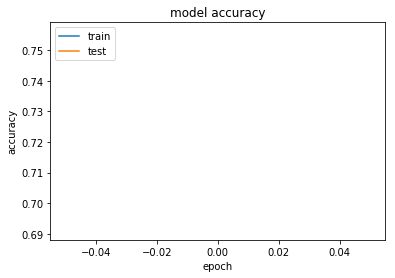

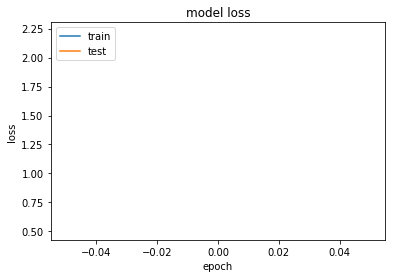

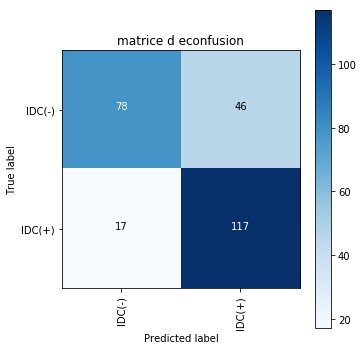

In [2]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_100m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_100m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
#simple model
def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')

def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 100 
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
     # checkpoint
    filepath="weights.data_aug.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
              verbose=1,
              epochs=1,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1030 samples, validate on 258 samples
Epoch 1/10
1030/1030 [==============================] - 3s 3ms/step - loss: 3.2316 - acc: 0.7340 - val_loss: 4.3944 - val_acc: 0.7016

Epoch 00001: val_acc improved from -inf to 0.70155, saving model to inception_module1.hdf5
Epoch 2/10
1030/1030 [==============================] - 1s 1ms/step - loss: 2.4673 - acc: 0.8126 - val_loss: 5.8377 - val_acc: 0.5969

Epoch 00002: val_acc did not improve from 0.70155
Epoch 3/10
1030/1030 [==============================] - 1s 1ms/step - loss: 2.1386 - acc: 0.8437 - val_loss: 3.1950 - val_acc: 0.7713

Epoch 00003: val_acc improved from 0.70155 to 0.77132, saving model to inception_module1.hdf5
Epoch 4/10
1030/1030 [==============================] - 1s 1ms/step - loss: 1.5898 - acc: 0.8786 - val_loss: 3.8946 - val_acc: 0.6783

Epoch 00004: val_acc did not improve from 0.77132
Epoch 5/10
1030/1030 [==============================] - 1s 1ms/step - loss: 2.0004 - acc: 0.8311 - val_loss: 4.7404 - val_acc: 0

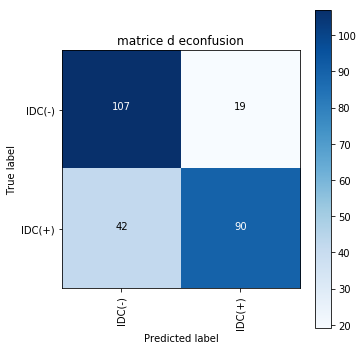

In [14]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module1.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=10,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1030 samples, validate on 258 samples
Epoch 1/5
1030/1030 [==============================] - 3s 3ms/step - loss: 2.7202 - acc: 0.6233 - val_loss: 2.4842 - val_acc: 0.5116

Epoch 00001: val_acc improved from -inf to 0.51163, saving model to test.hdf5
Epoch 2/5
1030/1030 [==============================] - 1s 846us/step - loss: 0.6616 - acc: 0.7553 - val_loss: 0.7146 - val_acc: 0.5504

Epoch 00002: val_acc improved from 0.51163 to 0.55039, saving model to test.hdf5
Epoch 3/5
1030/1030 [==============================] - 1s 823us/step - loss: 0.5750 - acc: 0.7845 - val_loss: 0.9111 - val_acc: 0.5078

Epoch 00003: val_acc did not improve from 0.55039
Epoch 4/5
1030/1030 [==============================] - 1s 820us/step - loss: 0.5771 - acc: 0.7777 - val_loss: 8.0649 - val_acc: 0.4922

Epoch 00004: val_acc did not improve from 0.55039
Epoch 5/5
1030/1030 [==============================] - 1s 833us/step - loss: 0.4294 - acc: 0.8097 - val_loss: 6.1195 - val_acc: 0.4922

Epoch 00005: val

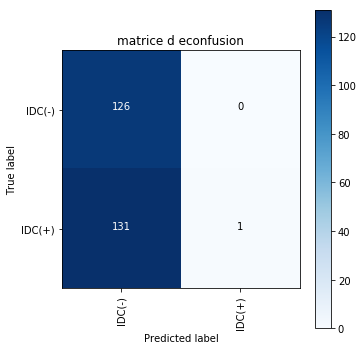

In [13]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="test.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=5,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1030 samples, validate on 258 samples
Epoch 1/100
1030/1030 [==============================] - 3s 3ms/step - loss: 2.7091 - acc: 0.7291 - val_loss: 3.5194 - val_acc: 0.7519

Epoch 00001: val_acc improved from -inf to 0.75194, saving model to inception_module_final.hdf5
Epoch 2/100
1030/1030 [==============================] - 1s 1ms/step - loss: 2.3834 - acc: 0.8175 - val_loss: 1.8407 - val_acc: 0.8527

Epoch 00002: val_acc improved from 0.75194 to 0.85271, saving model to inception_module_final.hdf5
Epoch 3/100
1030/1030 [==============================] - 1s 1ms/step - loss: 1.9486 - acc: 0.8495 - val_loss: 1.7588 - val_acc: 0.8256

Epoch 00003: val_acc did not improve from 0.85271
Epoch 4/100
1030/1030 [==============================] - 1s 1ms/step - loss: 1.7864 - acc: 0.8534 - val_loss: 5.4370 - val_acc: 0.6240

Epoch 00004: val_acc did not improve from 0.85271
Epoch 5/100
1030/1030 [==============================] - 1s 1ms/step - loss: 1.5725 - acc: 0.8680 - val_loss: 3.98

1030/1030 [==============================] - 1s 1ms/step - loss: 0.0471 - acc: 0.9971 - val_loss: 1.5527 - val_acc: 0.8450

Epoch 00044: val_acc did not improve from 0.85659
Epoch 45/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0470 - acc: 0.9971 - val_loss: 1.5516 - val_acc: 0.8450

Epoch 00045: val_acc did not improve from 0.85659
Epoch 46/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0470 - acc: 0.9971 - val_loss: 1.5498 - val_acc: 0.8488

Epoch 00046: val_acc did not improve from 0.85659
Epoch 47/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0470 - acc: 0.9971 - val_loss: 1.5489 - val_acc: 0.8450

Epoch 00047: val_acc did not improve from 0.85659
Epoch 48/100
1030/1030 [==============================] - 1s 1ms/step - loss: 0.0470 - acc: 0.9971 - val_loss: 1.5511 - val_acc: 0.8450

Epoch 00048: val_acc did not improve from 0.85659
Epoch 49/100
1030/1030 [==============================] - 1s 1ms/step - loss: 

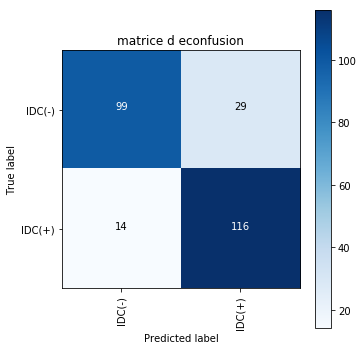

In [6]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    #output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    #bt1=BatchNormalization()(output)
    #dr1=Dropout(0.25)(bt1)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module_final.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1000 samples, validate on 250 samples
Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: 4.1629 - acc: 0.6630 - val_loss: 8.1880 - val_acc: 0.4920

Epoch 00001: val_acc improved from -inf to 0.49200, saving model to inception_module_100.hdf5
Epoch 2/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.6290 - acc: 0.7530 - val_loss: 7.1334 - val_acc: 0.5360

Epoch 00002: val_acc improved from 0.49200 to 0.53600, saving model to inception_module_100.hdf5
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.9934 - acc: 0.7930 - val_loss: 2.3748 - val_acc: 0.8240

Epoch 00003: val_acc improved from 0.53600 to 0.82400, saving model to inception_module_100.hdf5
Epoch 4/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.9046 - acc: 0.7980 - val_loss: 6.9262 - val_acc: 0.5480

Epoch 00004: val_acc did not improve from 0.82400
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - 

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0484 - acc: 0.9970 - val_loss: 1.4373 - val_acc: 0.8600

Epoch 00086: val_acc did not improve from 0.87600
Epoch 87/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0484 - acc: 0.9970 - val_loss: 1.4258 - val_acc: 0.8600

Epoch 00087: val_acc did not improve from 0.87600
Epoch 88/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0484 - acc: 0.9970 - val_loss: 1.4294 - val_acc: 0.8600

Epoch 00088: val_acc did not improve from 0.87600
Epoch 89/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0484 - acc: 0.9970 - val_loss: 1.4328 - val_acc: 0.8600

Epoch 00089: val_acc did not improve from 0.87600
Epoch 90/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0484 - acc: 0.9970 - val_loss: 1.4316 - val_acc: 0.8600

Epoch 00090: val_acc did not improve from 0.87600
Epoch 91/100
1000/1000 [==============================] - 2s 2ms/step - loss: 

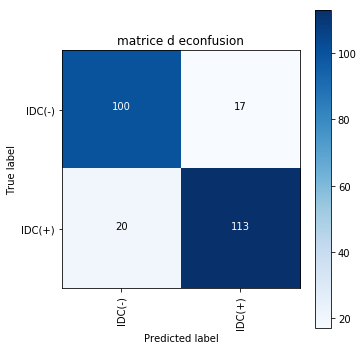

In [10]:
#les vrai experiances commence là
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    #output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    #bt1=BatchNormalization()(output)
    #dr1=Dropout(0.25)(bt1)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3,tower_4], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module_100.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 1000 samples, validate on 250 samples
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.7785 - acc: 0.6700 - val_loss: 7.4834 - val_acc: 0.5280

Epoch 00001: val_acc improved from -inf to 0.52800, saving model to inception_module_40.hdf5
Epoch 2/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.2087 - acc: 0.7820 - val_loss: 7.4504 - val_acc: 0.5360

Epoch 00002: val_acc improved from 0.52800 to 0.53600, saving model to inception_module_40.hdf5
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.8517 - acc: 0.8010 - val_loss: 2.8989 - val_acc: 0.8120

Epoch 00003: val_acc improved from 0.53600 to 0.81200, saving model to inception_module_40.hdf5
Epoch 4/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.0945 - acc: 0.7880 - val_loss: 4.4080 - val_acc: 0.6960

Epoch 00004: val_acc did not improve from 0.81200
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - los

1000/1000 [==============================] - 2s 2ms/step - loss: 0.1773 - acc: 0.9890 - val_loss: 1.3476 - val_acc: 0.8800

Epoch 00043: val_acc did not improve from 0.88400
Epoch 44/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1773 - acc: 0.9890 - val_loss: 1.3577 - val_acc: 0.8840

Epoch 00044: val_acc did not improve from 0.88400
Epoch 45/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1773 - acc: 0.9890 - val_loss: 1.3560 - val_acc: 0.8840

Epoch 00045: val_acc did not improve from 0.88400
Epoch 46/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1776 - acc: 0.9890 - val_loss: 1.3980 - val_acc: 0.8800

Epoch 00046: val_acc did not improve from 0.88400
Epoch 47/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2139 - acc: 0.9830 - val_loss: 2.6916 - val_acc: 0.8120

Epoch 00047: val_acc did not improve from 0.88400
Epoch 48/100
1000/1000 [==============================] - 2s 2ms/step - loss: 

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0967 - acc: 0.9940 - val_loss: 3.2632 - val_acc: 0.7440

Epoch 00087: val_acc did not improve from 0.88400
Epoch 88/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0967 - acc: 0.9940 - val_loss: 2.9773 - val_acc: 0.7680

Epoch 00088: val_acc did not improve from 0.88400
Epoch 89/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0967 - acc: 0.9940 - val_loss: 1.4935 - val_acc: 0.8880

Epoch 00089: val_acc improved from 0.88400 to 0.88800, saving model to inception_module_40.hdf5
Epoch 90/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0967 - acc: 0.9940 - val_loss: 1.4641 - val_acc: 0.8880

Epoch 00090: val_acc did not improve from 0.88800
Epoch 91/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0967 - acc: 0.9940 - val_loss: 1.4547 - val_acc: 0.8880

Epoch 00091: val_acc did not improve from 0.88800
Epoch 92/100
1000/1000 [========

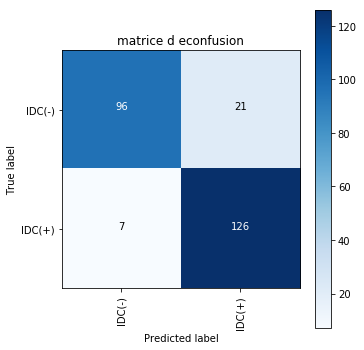

In [9]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_40m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    #output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    #bt1=BatchNormalization()(output)
    #dr1=Dropout(0.25)(bt1)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3,tower_4], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module_40.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 33856)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               4333696   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

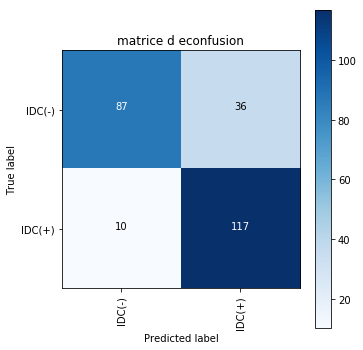

In [12]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.load_weights("weights.traint_100zoom_modelsimple_avec_crop.hdf5")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 3968 samples, validate on 992 samples
Epoch 1/100
3968/3968 [==============================] - 8s 2ms/step - loss: 2.6140 - acc: 0.8097 - val_loss: 3.9365 - val_acc: 0.7359

Epoch 00001: val_acc improved from -inf to 0.73589, saving model to inception_module_final.hdf5
Epoch 2/100
3968/3968 [==============================] - 6s 2ms/step - loss: 2.3890 - acc: 0.8385 - val_loss: 7.6431 - val_acc: 0.5222

Epoch 00002: val_acc did not improve from 0.73589
Epoch 3/100
3968/3968 [==============================] - 6s 2ms/step - loss: 2.3238 - acc: 0.8402 - val_loss: 6.9220 - val_acc: 0.5585

Epoch 00003: val_acc did not improve from 0.73589
Epoch 4/100
3968/3968 [==============================] - 6s 2ms/step - loss: 2.1192 - acc: 0.8556 - val_loss: 2.1787 - val_acc: 0.8397

Epoch 00004: val_acc improved from 0.73589 to 0.83972, saving model to inception_module_final.hdf5
Epoch 5/100
3968/3968 [==============================] - 6s 2ms/step - loss: 2.0285 - acc: 0.8624 - val_loss: 4.76

3968/3968 [==============================] - 6s 2ms/step - loss: 0.2572 - acc: 0.9808 - val_loss: 1.7020 - val_acc: 0.8679

Epoch 00044: val_acc did not improve from 0.87097
Epoch 45/100
3968/3968 [==============================] - 6s 2ms/step - loss: 0.2425 - acc: 0.9816 - val_loss: 2.0262 - val_acc: 0.8377

Epoch 00045: val_acc did not improve from 0.87097
Epoch 46/100
3968/3968 [==============================] - 7s 2ms/step - loss: 0.2649 - acc: 0.9786 - val_loss: 1.8625 - val_acc: 0.8548

Epoch 00046: val_acc did not improve from 0.87097
Epoch 47/100
3968/3968 [==============================] - 7s 2ms/step - loss: 0.2039 - acc: 0.9849 - val_loss: 1.8494 - val_acc: 0.8589

Epoch 00047: val_acc did not improve from 0.87097
Epoch 48/100
3968/3968 [==============================] - 6s 2ms/step - loss: 0.2078 - acc: 0.9856 - val_loss: 1.7243 - val_acc: 0.8659

Epoch 00048: val_acc did not improve from 0.87097
Epoch 49/100
3968/3968 [==============================] - 6s 2ms/step - loss: 

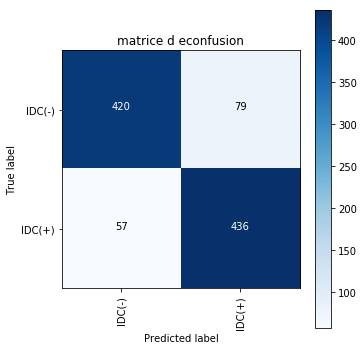

In [6]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoo.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    #output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    #bt1=BatchNormalization()(output)
    #dr1=Dropout(0.25)(bt1)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3,tower_4], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module_final.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 996 samples, validate on 250 samples
Epoch 1/100
996/996 [==============================] - 4s 4ms/step - loss: 2.4467 - acc: 0.7892 - val_loss: 5.6230 - val_acc: 0.6240

Epoch 00001: val_acc improved from -inf to 0.62400, saving model to inception_module_200.hdf5
Epoch 2/100
996/996 [==============================] - 2s 2ms/step - loss: 1.9951 - acc: 0.8675 - val_loss: 8.5748 - val_acc: 0.4680

Epoch 00002: val_acc did not improve from 0.62400
Epoch 3/100
996/996 [==============================] - 2s 2ms/step - loss: 2.0515 - acc: 0.8604 - val_loss: 7.8070 - val_acc: 0.4880

Epoch 00003: val_acc did not improve from 0.62400
Epoch 4/100
996/996 [==============================] - 2s 2ms/step - loss: 1.8229 - acc: 0.8745 - val_loss: 2.6375 - val_acc: 0.8240

Epoch 00004: val_acc improved from 0.62400 to 0.82400, saving model to inception_module_200.hdf5
Epoch 5/100
996/996 [==============================] - 2s 2ms/step - loss: 1.6747 - acc: 0.8896 - val_loss: 8.5748 - val_acc: 0


Epoch 00043: val_acc did not improve from 0.88400
Epoch 44/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8416 - acc: 0.9478 - val_loss: 2.2701 - val_acc: 0.8400

Epoch 00044: val_acc did not improve from 0.88400
Epoch 45/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8418 - acc: 0.9478 - val_loss: 1.8053 - val_acc: 0.8560

Epoch 00045: val_acc did not improve from 0.88400
Epoch 46/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8427 - acc: 0.9468 - val_loss: 1.9149 - val_acc: 0.8680

Epoch 00046: val_acc did not improve from 0.88400
Epoch 47/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8415 - acc: 0.9478 - val_loss: 1.8519 - val_acc: 0.8640

Epoch 00047: val_acc did not improve from 0.88400
Epoch 48/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8415 - acc: 0.9478 - val_loss: 1.7891 - val_acc: 0.8720

Epoch 00048: val_acc did not improve from 0.88400
Epoch 49/100
996/996 [==


Epoch 00087: val_acc did not improve from 0.88800
Epoch 88/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8253 - acc: 0.9488 - val_loss: 2.8195 - val_acc: 0.8080

Epoch 00088: val_acc did not improve from 0.88800
Epoch 89/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8253 - acc: 0.9488 - val_loss: 2.7560 - val_acc: 0.8080

Epoch 00089: val_acc did not improve from 0.88800
Epoch 90/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8253 - acc: 0.9488 - val_loss: 2.6676 - val_acc: 0.8080

Epoch 00090: val_acc did not improve from 0.88800
Epoch 91/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8253 - acc: 0.9488 - val_loss: 2.6034 - val_acc: 0.8120

Epoch 00091: val_acc did not improve from 0.88800
Epoch 92/100
996/996 [==============================] - 2s 2ms/step - loss: 0.8316 - acc: 0.9468 - val_loss: 1.9237 - val_acc: 0.8680

Epoch 00092: val_acc did not improve from 0.88800
Epoch 93/100
996/996 [==

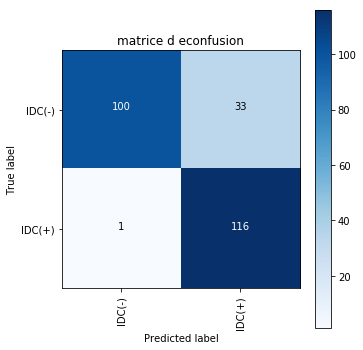

In [7]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_200m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_200m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    #output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    #bt1=BatchNormalization()(output)
    #dr1=Dropout(0.25)(bt1)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3,tower_4], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module_200.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 940 samples, validate on 236 samples
Epoch 1/100
940/940 [==============================] - 4s 4ms/step - loss: 3.1684 - acc: 0.7213 - val_loss: 8.4689 - val_acc: 0.4746

Epoch 00001: val_acc improved from -inf to 0.47458, saving model to inception_module_400.hdf5
Epoch 2/100
940/940 [==============================] - 1s 2ms/step - loss: 3.0682 - acc: 0.7979 - val_loss: 5.1217 - val_acc: 0.6568

Epoch 00002: val_acc improved from 0.47458 to 0.65678, saving model to inception_module_400.hdf5
Epoch 3/100
940/940 [==============================] - 1s 2ms/step - loss: 2.1741 - acc: 0.8511 - val_loss: 5.3962 - val_acc: 0.6483

Epoch 00003: val_acc did not improve from 0.65678
Epoch 4/100
940/940 [==============================] - 2s 2ms/step - loss: 2.4367 - acc: 0.8266 - val_loss: 5.5451 - val_acc: 0.6398

Epoch 00004: val_acc did not improve from 0.65678
Epoch 5/100
940/940 [==============================] - 2s 2ms/step - loss: 2.0527 - acc: 0.8564 - val_loss: 2.2652 - val_acc: 0

940/940 [==============================] - 1s 2ms/step - loss: 0.5316 - acc: 0.9670 - val_loss: 2.0275 - val_acc: 0.8390

Epoch 00087: val_acc did not improve from 0.88136
Epoch 88/100
940/940 [==============================] - 2s 2ms/step - loss: 0.5316 - acc: 0.9670 - val_loss: 1.9772 - val_acc: 0.8390

Epoch 00088: val_acc did not improve from 0.88136
Epoch 89/100
940/940 [==============================] - 1s 2ms/step - loss: 0.5316 - acc: 0.9670 - val_loss: 1.9942 - val_acc: 0.8390

Epoch 00089: val_acc did not improve from 0.88136
Epoch 90/100
940/940 [==============================] - 1s 2ms/step - loss: 0.5316 - acc: 0.9670 - val_loss: 1.9558 - val_acc: 0.8390

Epoch 00090: val_acc did not improve from 0.88136
Epoch 91/100
940/940 [==============================] - 1s 2ms/step - loss: 0.5316 - acc: 0.9670 - val_loss: 1.9180 - val_acc: 0.8432

Epoch 00091: val_acc did not improve from 0.88136
Epoch 92/100
940/940 [==============================] - 1s 2ms/step - loss: 0.5316 - acc

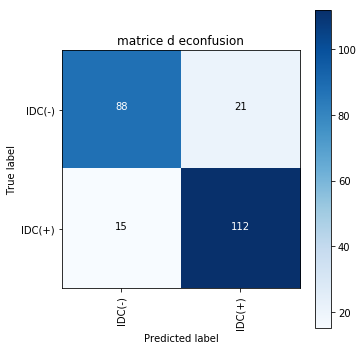

In [8]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_400m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_400m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]

# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    from keras.layers import Input
    input_img = Input(shape = (img_rows, img_cols, 3))
    tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    #output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    #bt1=BatchNormalization()(output)
    #dr1=Dropout(0.25)(bt1)
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_4 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

    tower_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_5 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

    tower_6 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_6 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3,tower_4], axis = 3)
    bt1=BatchNormalization()(output)
    dr1=Dropout(0.25)(bt1)
    d2 = Flatten()(bt1)
    
    out    = Dense(2, activation='softmax')(d2)
    from keras.models import Model
    model = Model([input_img], out)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="inception_module_400.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()